## Reserve and configure resources on KVM

Before you run this experiment, you will:

-   define the specific configuration of resources you need.
-   “instantiate” an experiment with your reserved resources.
-   wait for your resources to be configured.
-   log in to resources to carry out the experiment.

This exercise will guide you through those steps.

### Configure environment

In [2]:
import openstack, chi, chi.ssh, chi.network, chi.server, os

In this section, we configure the Chameleon Python client.

For this experiment, we’re going to use the KVM@TACC site, which we indicate below.

We also need to specify the name of the Chameleon “project” that this experiment is part of. The project name will have the format “CHI-XXXXXX”, where the last part is a 6-digit number, and you can find it on your [user dashboard](https://chameleoncloud.org/user/dashboard/).

In the cell below, replace the project ID with your own project ID, then run the cell.

In [3]:
chi.use_site("KVM@TACC")
PROJECT_NAME = "CHI-231138"
chi.set("project_name", PROJECT_NAME)

# configure openstacksdk for actions unsupported by python-chi
os_conn = chi.clients.connection()


Now using KVM@TACC:
URL: https://kvm.tacc.chameleoncloud.org
Location: Austin, Texas, USA
Support contact: help@chameleoncloud.org


### Define configuration for this experiment (3 VMs)

For this specific experiment, we will need four virtual machines connected to a common network. Each of the virtual machines will be of the `m1.medium` type, with 4 VCPUs, 8 GB memory, 40 GB disk space.

In [5]:
username = os.getenv('USER')

node_conf = [
 {'name': "node-0",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu22.04', 'packages': ["virtualenv"], 'bastion': True}, 
 {'name': "node-1",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu22.04', 'packages': ["virtualenv"], 'bastion': False}, 
 {'name': "node-2",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu22.04', 'packages': ["virtualenv"], 'bastion': False},
 {'name': "node-3",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu22.04', 'packages': ["virtualenv"], 'bastion': False}
]
net_conf = [
 {"name": "net0", "subnet": "192.168.1.0/24", "nodes": [{"name": "node-0",   "addr": "192.168.1.10"}, {"name": "node-1", "addr": "192.168.1.11"}, {"name": "node-2", "addr": "192.168.1.12"}, {"name": "node-3",   "addr": "192.168.1.13"}]},
]
route_conf = []

### Configure resources

Now, we will prepare the VMs and network links that our experiment requires.

First, we will prepare a “public” network that we will use for SSH access to our VMs -

In [6]:
public_net = os_conn.network.create_network(name="public_net_" + username)
public_net_id = public_net.get("id")
public_subnet = os_conn.network.create_subnet(
    name="public_subnet_" + username,
    network_id=public_net.get("id"),
    ip_version='4',
    cidr="192.168.10.0/24",
    gateway_ip="192.168.10.1",
    is_dhcp_enabled = True
)

Next, we will prepare the “experiment” networks -

In [9]:
nets = []
net_ids = []
subnets = []
for n in net_conf:
    exp_net = os_conn.network.create_network(name="exp_" + n['name']  + '_' + username)
    exp_net_id = exp_net.get("id")
    os_conn.network.update_network(exp_net, is_port_security_enabled=False)
    exp_subnet = os_conn.network.create_subnet(
        name="exp_subnet_" + n['name']  + '_' + username,
        network_id=exp_net.get("id"),
        ip_version='4',
        cidr=n['subnet'],
        gateway_ip=None,
        is_dhcp_enabled = True
    )
    nets.append(exp_net)
    net_ids.append(exp_net_id)
    subnets.append(exp_subnet)

Now we create the VMs -

In [10]:
servers = []
server_ids = []
for i, n in enumerate(node_conf, start=10):
    image_uuid = os_conn.image.find_image(n['image']).id
    flavor_uuid = os_conn.compute.find_flavor(n['flavor']).id
    # find out details of exp interface(s)
    nics = [{'net-id': chi.network.get_network_id( "exp_" + net['name']  + '_' + username ), 'v4-fixed-ip': node['addr']} for net in net_conf for node in net['nodes'] if node['name']==n['name']]
    # also include a public network interface
    nics.insert(0, {"net-id": public_net_id, "v4-fixed-ip":"192.168.10." + str(i)})
    server = chi.server.create_server(
        server_name=n['name'] + "_" + username,
        image_id=image_uuid,
        flavor_id=flavor_uuid,
        nics=nics
    )
    servers.append(server)
    server_ids.append(chi.server.get_server(n['name'] + "_" + username).id)

We wait for all servers to come up before we proceed -

In [11]:
for server_id in server_ids:
    chi.server.wait_for_active(server_id)

Next, we will set up SSH access to the VMs.

First, we will make sure the “public” network is connected to the Internet. Then, we will configure it to permit SSH access on port 22 for each port connected to this network.

In [12]:
# connect them to the Internet on the "public" network (e.g. for software installation)
router = chi.network.create_router('inet_router_' + username, gw_network_name='public')
chi.network.add_subnet_to_router(router.get("id"), public_subnet.get("id"))

{'network_id': '716cb07f-2c92-412d-b003-73f32e4f8fe3',
 'tenant_id': '13a1ac1ce275484caedc3394339486a1',
 'subnet_id': '7777643d-b0fa-4533-9365-b24a063f8671',
 'subnet_ids': ['7777643d-b0fa-4533-9365-b24a063f8671'],
 'port_id': 'ff865f6c-5de7-406d-ac95-b7cdd40d4851',
 'id': '6c88fd20-7678-4ba1-8c32-c628ad5a6d37'}

In [13]:
# prepare SSH access on the servers that serve in "bastion" role
# WARNING: this relies on undocumented behavior of associate_floating_ip 
# that it associates the IP with the first port on the server
server_ips = ["129.114.27.11"]
# for i, n in enumerate(node_conf):
#     if 'bastion' in n and n['bastion']:
#         ip = chi.server.associate_floating_ip(server_ids[i])
#         server_ips.append(ip)

In [14]:
if not os_conn.get_security_group("Allow SSH"):
    os_conn.create_security_group("Allow SSH", "Enable SSH traffic on TCP port 22")
    os_conn.create_security_group_rule("Allow SSH", port_range_min=22, port_range_max=22, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

security_group_id = os_conn.get_security_group("Allow SSH").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        os_conn.network.update_port(port['id'], security_groups=[security_group_id])

In [15]:
for ip in server_ips:
    chi.server.wait_for_tcp(ip, port=22)

The following cell may raise an error if some of your nodes are still getting set up! If that happens, wait a few minutes and try again. (And then a few minutes more, and try again, if it still raises an error.)

In [16]:
primary_remote = chi.ssh.Remote(server_ips[0])
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
server_remotes = [chi.ssh.Remote(physical_ip, gateway=primary_remote) for physical_ip in physical_ips]

Finally, we need to configure our resources, including software package installation and network configuration.

In [17]:
import time
for i, n in enumerate(node_conf):
    remote = server_remotes[i]
    # enable forwarding
    remote.run(f"sudo sysctl -w net.ipv4.ip_forward=1") 
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=192.168.0.0/16 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=172.16.0.0/12 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=10.0.0.0/8 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=127.0.0.0/8 --permanent")
    # these are required for etcd
    remote.run(f"sudo firewall-cmd --zone=public --add-port=4001/tcp")
    remote.run(f"sudo firewall-cmd --zone=public --add-port=2379-2380/tcp")
    time.sleep(3)

/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 129.114.27.11: b'9ff235e1d44d5ecff1fcc5f84efd4ce5'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.10: b'9ff235e1d44d5ecff1fcc5f84efd4ce5'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.11: b'0d7734a5c081fc3238ce05db53bbb73f'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.12: b'408bbf8044b6f210243f664043fe95ae'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.13: b'7fa460c526a70c0b61461a789c9b3a5e'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success


In [18]:
for i, n in enumerate(node_conf):
    # install packages
    if len(n['packages']):
            remote = server_remotes[i]
            remote.run(f"sudo apt update; sudo apt -y install " + " ".join(n['packages'])) 

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2036 kB]
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2271 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [13.3 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2761 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [580 B]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [958 kB]
Get:11 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [17.9 kB]
Get:12 http://nova.clouds.archiv

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  python3-distlib python3-filelock python3-pip python3-platformdirs
  python3-virtualenv python3-wheel python3-wheel-whl
Suggested packages:
  python2-pip-whl python2-setuptools-whl
The following NEW packages will be installed:
  python3-distlib python3-filelock python3-pip python3-platformdirs
  python3-virtualenv python3-wheel python3-wheel-whl virtualenv
0 upgraded, 8 newly installed, 0 to remove and 48 not upgraded.
Need to get 1750 kB of archives.
After this operation, 9000 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-distlib all 0.3.4-1 [269 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-filelock all 3.6.0-1 [8788 B]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-wheel all 0.37.1-2ubuntu0.22.04.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 1750 kB in 1s (2391 kB/s)
Selecting previously unselected package python3-distlib.
(Reading database ... 84249 files and directories currently installed.)
Preparing to unpack .../0-python3-distlib_0.3.4-1_all.deb ...
Unpacking python3-distlib (0.3.4-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../1-python3-filelock_3.6.0-1_all.deb ...
Unpacking python3-filelock (3.6.0-1) ...
Selecting previously unselected package python3-wheel.
Preparing to unpack .../2-python3-wheel_0.37.1-2ubuntu0.22.04.1_all.deb ...
Unpacking python3-wheel (0.37.1-2ubuntu0.22.04.1) ...
Selecting previously unselected package python3-pip.
Preparing to unpack .../3-python3-pip_22.0.2+dfsg-1ubuntu0.5_all.deb ...
Unpacking python3-pip (22.0.2+dfsg-1ubuntu0.5) ...
Selecting previously unselected package python3-platformdirs.
Preparing to unpack .../4-python3-platformdirs_2.5.1-1_all.deb ...
Unpacking python3-platformdirs (2.5.1-1) ...
Selecting previously unselected packa

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2036 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [13.3 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2761 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [580 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [958 kB]
Get:8 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [19.5 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [37.6 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [224 B]
Get:12 http://nova.clouds.archive

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  python3-distlib python3-filelock python3-pip python3-platformdirs
  python3-virtualenv python3-wheel python3-wheel-whl
Suggested packages:
  python2-pip-whl python2-setuptools-whl
The following NEW packages will be installed:
  python3-distlib python3-filelock python3-pip python3-platformdirs
  python3-virtualenv python3-wheel python3-wheel-whl virtualenv
0 upgraded, 8 newly installed, 0 to remove and 48 not upgraded.
Need to get 1750 kB of archives.
After this operation, 9000 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-distlib all 0.3.4-1 [269 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-filelock all 3.6.0-1 [8788 B]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-wheel all 0.37.1-2ubuntu0.22.04.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 1750 kB in 1s (1233 kB/s)
Selecting previously unselected package python3-distlib.
(Reading database ... 84249 files and directories currently installed.)
Preparing to unpack .../0-python3-distlib_0.3.4-1_all.deb ...
Unpacking python3-distlib (0.3.4-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../1-python3-filelock_3.6.0-1_all.deb ...
Unpacking python3-filelock (3.6.0-1) ...
Selecting previously unselected package python3-wheel.
Preparing to unpack .../2-python3-wheel_0.37.1-2ubuntu0.22.04.1_all.deb ...
Unpacking python3-wheel (0.37.1-2ubuntu0.22.04.1) ...
Selecting previously unselected package python3-pip.
Preparing to unpack .../3-python3-pip_22.0.2+dfsg-1ubuntu0.5_all.deb ...
Unpacking python3-pip (22.0.2+dfsg-1ubuntu0.5) ...
Selecting previously unselected package python3-platformdirs.
Preparing to unpack .../4-python3-platformdirs_2.5.1-1_all.deb ...
Unpacking python3-platformdirs (2.5.1-1) ...
Selecting previously unselected packa

Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2271 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2036 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [17.9 kB]
Get:8 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2867 kB]
Get:9 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [612 B]
Get:10 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1181 kB]
Get:11 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metada

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  python3-distlib python3-filelock python3-pip python3-platformdirs
  python3-virtualenv python3-wheel python3-wheel-whl
Suggested packages:
  python2-pip-whl python2-setuptools-whl
The following NEW packages will be installed:
  python3-distlib python3-filelock python3-pip python3-platformdirs
  python3-virtualenv python3-wheel python3-wheel-whl virtualenv
0 upgraded, 8 newly installed, 0 to remove and 48 not upgraded.
Need to get 1750 kB of archives.
After this operation, 9000 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-distlib all 0.3.4-1 [269 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-filelock all 3.6.0-1 [8788 B]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-wheel all 0.37.1-2ubuntu0.22.04.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 1750 kB in 1s (2936 kB/s)
Selecting previously unselected package python3-distlib.
(Reading database ... 84249 files and directories currently installed.)
Preparing to unpack .../0-python3-distlib_0.3.4-1_all.deb ...
Unpacking python3-distlib (0.3.4-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../1-python3-filelock_3.6.0-1_all.deb ...
Unpacking python3-filelock (3.6.0-1) ...
Selecting previously unselected package python3-wheel.
Preparing to unpack .../2-python3-wheel_0.37.1-2ubuntu0.22.04.1_all.deb ...
Unpacking python3-wheel (0.37.1-2ubuntu0.22.04.1) ...
Selecting previously unselected package python3-pip.
Preparing to unpack .../3-python3-pip_22.0.2+dfsg-1ubuntu0.5_all.deb ...
Unpacking python3-pip (22.0.2+dfsg-1ubuntu0.5) ...
Selecting previously unselected package python3-platformdirs.
Preparing to unpack .../4-python3-platformdirs_2.5.1-1_all.deb ...
Unpacking python3-platformdirs (2.5.1-1) ...
Selecting previously unselected packa

Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2271 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2036 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [17.9 kB]
Get:8 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2867 kB]
Get:9 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [612 B]
Get:10 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1181 kB]
Get:11 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metada

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  python3-distlib python3-filelock python3-pip python3-platformdirs
  python3-virtualenv python3-wheel python3-wheel-whl
Suggested packages:
  python2-pip-whl python2-setuptools-whl
The following NEW packages will be installed:
  python3-distlib python3-filelock python3-pip python3-platformdirs
  python3-virtualenv python3-wheel python3-wheel-whl virtualenv
0 upgraded, 8 newly installed, 0 to remove and 48 not upgraded.
Need to get 1750 kB of archives.
After this operation, 9000 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-distlib all 0.3.4-1 [269 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/universe amd64 python3-filelock all 3.6.0-1 [8788 B]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-wheel all 0.37.1-2ubuntu0.22.04.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 1750 kB in 1s (3146 kB/s)
Selecting previously unselected package python3-distlib.
(Reading database ... 84249 files and directories currently installed.)
Preparing to unpack .../0-python3-distlib_0.3.4-1_all.deb ...
Unpacking python3-distlib (0.3.4-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../1-python3-filelock_3.6.0-1_all.deb ...
Unpacking python3-filelock (3.6.0-1) ...
Selecting previously unselected package python3-wheel.
Preparing to unpack .../2-python3-wheel_0.37.1-2ubuntu0.22.04.1_all.deb ...
Unpacking python3-wheel (0.37.1-2ubuntu0.22.04.1) ...
Selecting previously unselected package python3-pip.
Preparing to unpack .../3-python3-pip_22.0.2+dfsg-1ubuntu0.5_all.deb ...
Unpacking python3-pip (22.0.2+dfsg-1ubuntu0.5) ...
Selecting previously unselected package python3-platformdirs.
Preparing to unpack .../4-python3-platformdirs_2.5.1-1_all.deb ...
Unpacking python3-platformdirs (2.5.1-1) ...
Selecting previously unselected packa

In [19]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for remote in server_remotes:
    for h in hosts_txt:
        remote.run("echo %s | sudo tee -a /etc/hosts > /dev/null" % h)

In [7]:
# we also need to enable incoming traffic on the HTTP port
if not os_conn.get_security_group("Allow HTTP 8000"):
    os_conn.create_security_group("Allow HTTP 8000", "Enable HTTP traffic on TCP port 8000")
    os_conn.create_security_group_rule("Allow HTTP 8000", port_range_min=8000, port_range_max=8000, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

# add existing security group
security_group_id = os_conn.get_security_group("Allow HTTP 8000").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        pri_security_groups = port['security_groups']
        pri_security_groups.append(security_group_id)
        os_conn.network.update_port(port['id'], security_groups=pri_security_groups)

### Draw the network topology

The following cells will draw the network topology, for your reference.

In [21]:
!pip install networkx

In [22]:
nodes = [ (n['name'], {'color': 'pink'}) for n in net_conf ] + [(n['name'], {'color': 'lightblue'}) for n in node_conf ]
edges = [(net['name'], node['name'], 
          {'label': node['addr'] + '/' + net['subnet'].split("/")[1] }) if node['addr'] else (net['name'], node['name']) for net in net_conf for node in net['nodes'] ]

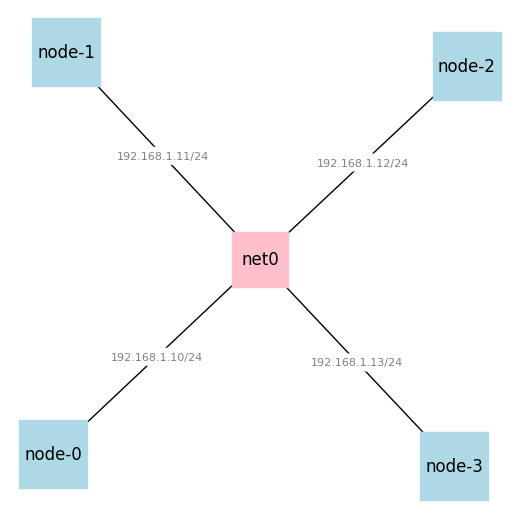

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Use Kubespray to prepare a Kubernetes cluster

Now that are resources are “up”, we will use Kubespray, a software utility for preparing and configuring a Kubernetes cluster, to set them up as a cluster.

In [24]:
remote = chi.ssh.Remote(server_ips[0])

In [25]:
# install Python libraries required for Kubespray
remote.run("virtualenv -p python3 myenv")
remote.run("git clone --branch release-2.22 https://github.com/kubernetes-sigs/kubespray.git")
remote.run("source myenv/bin/activate; cd kubespray; pip3 install -r requirements.txt")

/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 129.114.27.11: b'9ff235e1d44d5ecff1fcc5f84efd4ce5'
  warnings.warn(


created virtual environment CPython3.10.12.final.0-64 in 821ms
  creator CPython3Posix(dest=/home/cc/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/cc/.local/share/virtualenv)
    added seed packages: pip==22.0.2, setuptools==59.6.0, wheel==0.37.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


Cloning into 'kubespray'...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 KB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 KB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 8.4 MB/s eta 0

<Result cmd='source myenv/bin/activate; cd kubespray; pip3 install -r requirements.txt' exited=0>

In [26]:
# copy config files to correct locations
remote.run("mv kubespray/inventory/sample kubespray/inventory/mycluster")
remote.run("git clone https://github.com/teaching-on-testbeds/k8s.git")
remote.run("cp k8s/config/k8s-cluster.yml kubespray/inventory/mycluster/group_vars/k8s_cluster/k8s-cluster.yml")
remote.run("cp k8s/config/inventory.py    kubespray/contrib/inventory_builder/inventory.py")
remote.run("cp k8s/config/addons.yml      kubespray/inventory/mycluster/group_vars/k8s_cluster/addons.yml")

Cloning into 'k8s'...


<Result cmd='cp k8s/config/addons.yml      kubespray/inventory/mycluster/group_vars/k8s_cluster/addons.yml' exited=0>

In [27]:
# build inventory for this specific topology
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
physical_ips_str = " ".join(physical_ips)
remote.run(f"source myenv/bin/activate; declare -a IPS=({physical_ips_str});"+"cd kubespray; CONFIG_FILE=inventory/mycluster/hosts.yaml python3 contrib/inventory_builder/inventory.py ${IPS[@]}")


DEBUG: Adding group all
DEBUG: Adding group kube_control_plane
DEBUG: Adding group kube_node
DEBUG: Adding group etcd
DEBUG: Adding group k8s_cluster
DEBUG: Adding group calico_rr
DEBUG: adding host node-0 to group all
DEBUG: adding host node-1 to group all
DEBUG: adding host node-2 to group all
DEBUG: adding host node-3 to group all
DEBUG: adding host node-0 to group etcd
DEBUG: adding host node-1 to group etcd
DEBUG: adding host node-2 to group etcd
DEBUG: adding host node-0 to group kube_control_plane
DEBUG: adding host node-1 to group kube_control_plane
DEBUG: adding host node-0 to group kube_node
DEBUG: adding host node-1 to group kube_node
DEBUG: adding host node-2 to group kube_node
DEBUG: adding host node-3 to group kube_node


<Result cmd='source myenv/bin/activate; declare -a IPS=(192.168.1.10 192.168.1.11 192.168.1.12 192.168.1.13);cd kubespray; CONFIG_FILE=inventory/mycluster/hosts.yaml python3 contrib/inventory_builder/inventory.py ${IPS[@]}' exited=0>

In [28]:
# make sure "controller" node can SSH into the others
remote.run('ssh-keygen -t rsa -b 4096 -f ~/.ssh/id_rsa -q -N ""')
public_key = remote.run('cat ~/.ssh/id_rsa.pub').tail("stdout")[2:]

for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run(f'echo {public_key} >> ~/.ssh/authorized_keys') 

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDEFVkM3+kNiYR0wf4wv3aV2meX0riNYcw6ZNUXmaistBkMP8ZWfkV9BiZRjp+DosgP4nD8WAZAfix5Zdjh3KVq/jVBpd4ZhXeomL3crnNztJ3n2R3M1I485r0aCnNT3NhjAKZKG+itgA2j25Lbk3ErydnviCTXXLiqk3YQY7M2DOupVOn6rcoEimaqJDk9R8bskaQfHQhvVuqmUjMZlJzSherxcKVlKeka6cnk8x+QNDrKb6pCmz/Uzmvg0uiw2ynS6w8cSRNVyptf/Kfj1SZTKnjKz9jgzs49MxChWsTaXxhaSZymt72+vWBSZrhWbJqutnEBQ4jBE3TpH+xceKVyI27WYvpqTCa2y7QOKMU5OHQrPDybC+7mLVa2pchbKIvLeh7rC7isjHe2c7q54pArHKhAxYQrmgAXAR4E1cJeH5ykqyGmDkhYquN0RGlvZwVSzXlTkIuUwjNL6Cw/U9ufrEvd2Eow3byCqwe/7bt3FCFs+tUCHEcImGmlRcsnzw3jkFi8R0/sNla+jr0UeuwhemjYKwSSCcbVt2LBVHjqkQcy0Z678o0TIRAgAqNURudBfs2pn6IdsQ0EIowWok3Jxu2Q+Ny4RkXJKKhwiD3zaeIXqbuKtJ+7YAERTvd1BU4/uKCELq8v4ItgYzcP41yoOjxorhvVTuxH6ZFnmmPm3w== cc@node-0-vn2233-nyu-edu


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.10: b'9ff235e1d44d5ecff1fcc5f84efd4ce5'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.11: b'0d7734a5c081fc3238ce05db53bbb73f'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.12: b'408bbf8044b6f210243f664043fe95ae'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.13: b'7fa460c526a70c0b61461a789c9b3a5e'
  warnings.warn(


The following cell will actually build the cluster. It will take a long time, and you may see many warnings in the output - that’s OK. The instructions below explain how to tell whether it was successful or not.

The output will be very long, so it will be truncated by default. When you see

    Output of this cell has been trimmed on the initial display.
    Displaying the first 50 top outputs.
    Click on this message to get the complete output.

at the end, click in order to see the rest of the output.

When the process is finished, you will see a “PLAY RECAP” in the output (near the end):

    PLAY RECAP *********************************************************************
    localhost                  : ok=3    changed=0    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
    node-0                     : ok=752  changed=149  unreachable=0    failed=0    skipped=1276 rescued=0    ignored=8   
    node-1                     : ok=652  changed=136  unreachable=0    failed=0    skipped=1124 rescued=0    ignored=3   
    node-2                     : ok=535  changed=112  unreachable=0    failed=0    skipped=797  rescued=0    ignored=2   

Make sure that each node shows `failed=0`. If not, you should re-run the cell to re-try the failed parts.

In [29]:
# build the cluster
remote.run("source myenv/bin/activate; cd kubespray; ansible-playbook -i inventory/mycluster/hosts.yaml  --become --become-user=root cluster.yml")

[WARNING]: Skipping callback plugin 'ara_default', unable to load



PLAY [localhost] ***************************************************************
Tuesday 07 January 2025  14:14:46 +0000 (0:00:00.042)       0:00:00.042 ******* 

TASK [Check 2.11.0 <= Ansible version < 2.13.0] ********************************
ok: [localhost] => {
    "changed": false,
    "msg": "All assertions passed"
}
Tuesday 07 January 2025  14:14:46 +0000 (0:00:00.045)       0:00:00.087 ******* 

TASK [Check that python netaddr is installed] **********************************
ok: [localhost] => {
    "changed": false,
    "msg": "All assertions passed"
}
Tuesday 07 January 2025  14:14:46 +0000 (0:00:00.136)       0:00:00.224 ******* 

TASK [Check that jinja is not too old (install via pip)] ***********************
ok: [localhost] => {
    "changed": false,
    "msg": "All assertions passed"
}


[WARNING]: Could not match supplied host pattern, ignoring: kube-master



PLAY [Add kube-master nodes to kube_control_plane] *****************************
skipping: no hosts matched


[WARNING]: Could not match supplied host pattern, ignoring: kube-node
[WARNING]: Could not match supplied host pattern, ignoring: k8s-cluster
[WARNING]: Could not match supplied host pattern, ignoring: calico-rr
[WARNING]: Could not match supplied host pattern, ignoring: no-floating



PLAY [Add kube-node nodes to kube_node] ****************************************
skipping: no hosts matched

PLAY [Add k8s-cluster nodes to k8s_cluster] ************************************
skipping: no hosts matched

PLAY [Add calico-rr nodes to calico_rr] ****************************************
skipping: no hosts matched

PLAY [Add no-floating nodes to no_floating] ************************************
skipping: no hosts matched

PLAY [bastion[0]] **************************************************************


[WARNING]: Could not match supplied host pattern, ignoring: bastion


skipping: no hosts matched

PLAY [k8s_cluster:etcd:calico_rr] **********************************************
Tuesday 07 January 2025  14:14:46 +0000 (0:00:00.072)       0:00:00.296 ******* 
Tuesday 07 January 2025  14:14:46 +0000 (0:00:00.127)       0:00:00.424 ******* 
Tuesday 07 January 2025  14:14:46 +0000 (0:00:00.055)       0:00:00.479 ******* 
Tuesday 07 January 2025  14:14:46 +0000 (0:00:00.051)       0:00:00.530 ******* 
Tuesday 07 January 2025  14:14:46 +0000 (0:00:00.116)       0:00:00.647 ******* 
Tuesday 07 January 2025  14:14:47 +0000 (0:00:00.117)       0:00:00.764 ******* 
Tuesday 07 January 2025  14:14:47 +0000 (0:00:00.119)       0:00:00.883 ******* 
Tuesday 07 January 2025  14:14:47 +0000 (0:00:00.106)       0:00:00.989 ******* 
Tuesday 07 January 2025  14:14:47 +0000 (0:00:00.050)       0:00:01.040 ******* 
Tuesday 07 January 2025  14:14:47 +0000 (0:00:00.109)       0:00:01.149 ******* 
Tuesday 07 January 2025  14:14:47 +0000 (0:00:00.180)       0:00:01.329 ******* 


[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword



TASK [bootstrap-os : Fetch /etc/os-release] ************************************
ok: [node-0]
ok: [node-2]
ok: [node-1]
ok: [node-3]
Tuesday 07 January 2025  14:14:48 +0000 (0:00:00.448)       0:00:02.345 ******* 
Tuesday 07 January 2025  14:14:48 +0000 (0:00:00.083)       0:00:02.428 ******* 
Tuesday 07 January 2025  14:14:48 +0000 (0:00:00.072)       0:00:02.500 ******* 
Tuesday 07 January 2025  14:14:48 +0000 (0:00:00.075)       0:00:02.576 ******* 
Tuesday 07 January 2025  14:14:48 +0000 (0:00:00.074)       0:00:02.651 ******* 
Tuesday 07 January 2025  14:14:48 +0000 (0:00:00.074)       0:00:02.726 ******* 
Tuesday 07 January 2025  14:14:49 +0000 (0:00:00.074)       0:00:02.800 ******* 

TASK [bootstrap-os : include_tasks] ********************************************
included: /home/cc/kubespray/roles/bootstrap-os/tasks/bootstrap-debian.yml for node-0, node-1, node-2, node-3
Tuesday 07 January 2025  14:14:49 +0000 (0:00:00.106)       0:00:02.907 ******* 


[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword



TASK [bootstrap-os : Check if bootstrap is needed] *****************************
ok: [node-0]
ok: [node-3]
ok: [node-1]
ok: [node-2]
Tuesday 07 January 2025  14:14:49 +0000 (0:00:00.174)       0:00:03.081 ******* 


[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword



TASK [bootstrap-os : Check http::proxy in apt configuration files] *************
ok: [node-0]


[WARNING]: raw module does not support the environment keyword


ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:14:49 +0000 (0:00:00.201)       0:00:03.283 ******* 
Tuesday 07 January 2025  14:14:49 +0000 (0:00:00.090)       0:00:03.373 ******* 


[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword



TASK [bootstrap-os : Check https::proxy in apt configuration files] ************
ok: [node-0]


[WARNING]: raw module does not support the environment keyword


ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:14:49 +0000 (0:00:00.195)       0:00:03.569 ******* 
Tuesday 07 January 2025  14:14:49 +0000 (0:00:00.090)       0:00:03.660 ******* 
Tuesday 07 January 2025  14:14:50 +0000 (0:00:00.079)       0:00:03.739 ******* 
Tuesday 07 January 2025  14:14:50 +0000 (0:00:00.080)       0:00:03.820 ******* 

TASK [bootstrap-os : Set the ansible_python_interpreter fact] ******************
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:14:50 +0000 (0:00:00.122)       0:00:03.942 ******* 

TASK [bootstrap-os : Install dbus for the hostname module] *********************
ok: [node-1]
ok: [node-2]
ok: [node-3]
ok: [node-0]
Tuesday 07 January 2025  14:14:52 +0000 (0:00:02.540)       0:00:06.483 ******* 
Tuesday 07 January 2025  14:14:52 +0000 (0:00:00.076)       0:00:06.560 ******* 
Tuesday 07 January 2025  14:14:52 +0000 (0:00:00.078)       0:00:06.638 ******* 

TASK [bootstrap-os : Create remote_tmp for i

[WARNING]: flush_handlers task does not support when conditional


Tuesday 07 January 2025  14:16:43 +0000 (0:00:00.012)       0:01:57.134 ******* 
Tuesday 07 January 2025  14:16:43 +0000 (0:00:00.167)       0:01:57.301 ******* 

TASK [container-engine/containerd-common : containerd-common | check if fedora coreos] ***
ok: [node-1]
ok: [node-0]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:16:44 +0000 (0:00:00.641)       0:01:57.943 ******* 

TASK [container-engine/containerd-common : containerd-common | set is_ostree] ***
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:16:44 +0000 (0:00:00.166)       0:01:58.110 ******* 

TASK [container-engine/containerd-common : containerd-common | gather os specific variables] ***
ok: [node-0] => (item=/home/cc/kubespray/roles/container-engine/docker/vars/../vars/ubuntu.yml)
ok: [node-1] => (item=/home/cc/kubespray/roles/container-engine/docker/vars/../vars/ubuntu.yml)
ok: [node-2] => (item=/home/cc/kubespray/roles/container-engine/docker/vars/../vars/ubuntu.yml)
ok: [node-3

[WARNING]: noop task does not support when conditional



TASK [download : prep_kubeadm_images | Create kubeadm config] ******************
changed: [node-0]
changed: [node-1]
Tuesday 07 January 2025  14:18:43 +0000 (0:00:00.955)       0:03:57.612 ******* 

TASK [download : prep_kubeadm_images | Copy kubeadm binary from download dir to system path] ***
changed: [node-0]
changed: [node-1]
Tuesday 07 January 2025  14:18:44 +0000 (0:00:00.758)       0:03:58.371 ******* 

TASK [download : prep_kubeadm_images | Set kubeadm binary permissions] *********
ok: [node-0]
ok: [node-1]
Tuesday 07 January 2025  14:18:45 +0000 (0:00:00.563)       0:03:58.934 ******* 

TASK [download : prep_kubeadm_images | Generate list of required images] *******
ok: [node-0]
Tuesday 07 January 2025  14:18:45 +0000 (0:00:00.472)       0:03:59.406 ******* 

TASK [download : prep_kubeadm_images | Parse list of images] *******************
ok: [node-0] => (item=registry.k8s.io/kube-apiserver:v1.26.5)
ok: [node-0] => (item=registry.k8s.io/kube-controller-manager:v1.26.5)
ok: [n

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-2]
changed: [node-0]
changed: [node-1]
changed: [node-3]
Tuesday 07 January 2025  14:19:55 +0000 (0:00:11.243)       0:05:09.681 ******* 
Tuesday 07 January 2025  14:19:56 +0000 (0:00:00.055)       0:05:09.737 ******* 
Tuesday 07 January 2025  14:19:56 +0000 (0:00:00.155)       0:05:09.892 ******* 
Tuesday 07 January 2025  14:19:56 +0000 (0:00:00.124)       0:05:10.017 ******* 
Tuesday 07 January 2025  14:19:56 +0000 (0:00:00.128)       0:05:10.145 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-1]
ok: [node-2]
ok: [node-3]
ok: [node-0]
Tuesday 07 January 2025  14:19:57 +0000 (0:00:00.612)       0:05:10.757 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:19:57 +0000 (0:00:00.150)       0:05:10.908 ******* 

TASK [down

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-3]
changed: [node-0]
changed: [node-2]
changed: [node-1]
Tuesday 07 January 2025  14:20:21 +0000 (0:00:20.800)       0:05:35.254 ******* 
Tuesday 07 January 2025  14:20:21 +0000 (0:00:00.058)       0:05:35.314 ******* 
Tuesday 07 January 2025  14:20:21 +0000 (0:00:00.127)       0:05:35.441 ******* 
Tuesday 07 January 2025  14:20:21 +0000 (0:00:00.130)       0:05:35.571 ******* 
Tuesday 07 January 2025  14:20:21 +0000 (0:00:00.145)       0:05:35.716 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-1]
ok: [node-2]
ok: [node-3]
ok: [node-0]
Tuesday 07 January 2025  14:20:23 +0000 (0:00:01.125)       0:05:36.841 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:20:23 +0000 (0:00:00.155)       0:05:36.997 ******* 

TASK [down

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-3]
changed: [node-1]
changed: [node-2]
changed: [node-0]
Tuesday 07 January 2025  14:20:43 +0000 (0:00:16.774)       0:05:57.165 ******* 
Tuesday 07 January 2025  14:20:43 +0000 (0:00:00.056)       0:05:57.221 ******* 
Tuesday 07 January 2025  14:20:43 +0000 (0:00:00.127)       0:05:57.349 ******* 
Tuesday 07 January 2025  14:20:43 +0000 (0:00:00.130)       0:05:57.479 ******* 
Tuesday 07 January 2025  14:20:43 +0000 (0:00:00.123)       0:05:57.602 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-1]
ok: [node-0]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:20:44 +0000 (0:00:00.617)       0:05:58.220 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:20:44 +0000 (0:00:00.157)       0:05:58.378 ******* 

TASK [down

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-0]
changed: [node-1]
changed: [node-2]
changed: [node-3]
Tuesday 07 January 2025  14:20:58 +0000 (0:00:10.695)       0:06:12.508 ******* 
Tuesday 07 January 2025  14:20:58 +0000 (0:00:00.055)       0:06:12.564 ******* 
Tuesday 07 January 2025  14:20:58 +0000 (0:00:00.129)       0:06:12.693 ******* 
Tuesday 07 January 2025  14:20:59 +0000 (0:00:00.134)       0:06:12.827 ******* 
Tuesday 07 January 2025  14:20:59 +0000 (0:00:00.144)       0:06:12.972 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:20:59 +0000 (0:00:00.655)       0:06:13.627 ******* 

TASK [download : prep_download | Set a few facts] ******************************
ok: [node-0]
ok: [node-1]
Tuesday 07 January 2025  14:20:59 +0000 (0:00:00.091)       0:06:13.719 ******* 

TASK [download : download_file | Sta

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-2]
changed: [node-1]
changed: [node-0]
changed: [node-3]
Tuesday 07 January 2025  14:21:13 +0000 (0:00:01.647)       0:06:27.539 ******* 
Tuesday 07 January 2025  14:21:13 +0000 (0:00:00.065)       0:06:27.604 ******* 
Tuesday 07 January 2025  14:21:14 +0000 (0:00:00.151)       0:06:27.755 ******* 
Tuesday 07 January 2025  14:21:14 +0000 (0:00:00.140)       0:06:27.896 ******* 
Tuesday 07 January 2025  14:21:14 +0000 (0:00:00.141)       0:06:28.038 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-1]
ok: [node-0]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:21:14 +0000 (0:00:00.615)       0:06:28.654 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:21:15 +0000 (0:00:00.191)       0:06:28.846 ******* 

TASK [down

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-2]
changed: [node-0]
changed: [node-3]
Tuesday 07 January 2025  14:21:22 +0000 (0:00:03.433)       0:06:36.032 ******* 
Tuesday 07 January 2025  14:21:22 +0000 (0:00:00.059)       0:06:36.091 ******* 
Tuesday 07 January 2025  14:21:22 +0000 (0:00:00.134)       0:06:36.225 ******* 
Tuesday 07 January 2025  14:21:22 +0000 (0:00:00.122)       0:06:36.348 ******* 
Tuesday 07 January 2025  14:21:22 +0000 (0:00:00.126)       0:06:36.474 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-1]
ok: [node-2]
ok: [node-3]
ok: [node-0]
Tuesday 07 January 2025  14:21:23 +0000 (0:00:00.737)       0:06:37.211 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:21:23 +0000 (0:00:00.161)       0:06:37.373 ******* 

TASK [down

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-0]
changed: [node-2]
changed: [node-3]
Tuesday 07 January 2025  14:21:29 +0000 (0:00:02.860)       0:06:43.704 ******* 
Tuesday 07 January 2025  14:21:30 +0000 (0:00:00.057)       0:06:43.762 ******* 
Tuesday 07 January 2025  14:21:30 +0000 (0:00:00.123)       0:06:43.885 ******* 
Tuesday 07 January 2025  14:21:30 +0000 (0:00:00.120)       0:06:44.006 ******* 
Tuesday 07 January 2025  14:21:30 +0000 (0:00:00.268)       0:06:44.274 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-1]
ok: [node-0]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:21:31 +0000 (0:00:00.647)       0:06:44.922 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:21:31 +0000 (0:00:00.179)       0:06:45.102 ******* 

TASK [down

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-2]
changed: [node-3]
changed: [node-0]
Tuesday 07 January 2025  14:21:38 +0000 (0:00:04.010)       0:06:52.556 ******* 
Tuesday 07 January 2025  14:21:38 +0000 (0:00:00.056)       0:06:52.612 ******* 
Tuesday 07 January 2025  14:21:39 +0000 (0:00:00.122)       0:06:52.734 ******* 
Tuesday 07 January 2025  14:21:39 +0000 (0:00:00.122)       0:06:52.857 ******* 
Tuesday 07 January 2025  14:21:39 +0000 (0:00:00.118)       0:06:52.975 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-1]
ok: [node-2]
ok: [node-3]
ok: [node-0]
Tuesday 07 January 2025  14:21:39 +0000 (0:00:00.721)       0:06:53.697 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
Tuesday 07 January 2025  14:21:40 +0000 (0:00:00.089)       0:06:53.786 ******* 

TASK [download : set_container_facts

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-0]
Tuesday 07 January 2025  14:21:45 +0000 (0:00:03.231)       0:06:59.429 ******* 
Tuesday 07 January 2025  14:21:45 +0000 (0:00:00.055)       0:06:59.485 ******* 
Tuesday 07 January 2025  14:21:45 +0000 (0:00:00.085)       0:06:59.571 ******* 
Tuesday 07 January 2025  14:21:45 +0000 (0:00:00.083)       0:06:59.654 ******* 
Tuesday 07 January 2025  14:21:46 +0000 (0:00:00.089)       0:06:59.743 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-1]
ok: [node-0]
Tuesday 07 January 2025  14:21:46 +0000 (0:00:00.473)       0:07:00.216 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
Tuesday 07 January 2025  14:21:46 +0000 (0:00:00.085)       0:07:00.302 ******* 

TASK [download : set_container_facts | Display the name of the image being processed] ***
ok: [nod

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-0]
changed: [node-1]
Tuesday 07 January 2025  14:21:52 +0000 (0:00:04.054)       0:07:06.634 ******* 
Tuesday 07 January 2025  14:21:52 +0000 (0:00:00.058)       0:07:06.692 ******* 
Tuesday 07 January 2025  14:21:53 +0000 (0:00:00.081)       0:07:06.773 ******* 
Tuesday 07 January 2025  14:21:53 +0000 (0:00:00.087)       0:07:06.861 ******* 
Tuesday 07 January 2025  14:21:53 +0000 (0:00:00.084)       0:07:06.946 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
Tuesday 07 January 2025  14:21:53 +0000 (0:00:00.451)       0:07:07.397 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
Tuesday 07 January 2025  14:21:53 +0000 (0:00:00.086)       0:07:07.484 ******* 

TASK [download : set_container_facts | Display the name of the image being processed] ***
ok: [nod

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-0]
Tuesday 07 January 2025  14:22:05 +0000 (0:00:09.164)       0:07:18.852 ******* 
Tuesday 07 January 2025  14:22:05 +0000 (0:00:00.056)       0:07:18.908 ******* 
Tuesday 07 January 2025  14:22:05 +0000 (0:00:00.101)       0:07:19.010 ******* 
Tuesday 07 January 2025  14:22:05 +0000 (0:00:00.081)       0:07:19.091 ******* 
Tuesday 07 January 2025  14:22:05 +0000 (0:00:00.079)       0:07:19.171 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
Tuesday 07 January 2025  14:22:05 +0000 (0:00:00.467)       0:07:19.639 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:22:06 +0000 (0:00:00.157)       0:07:19.796 ******* 

TASK [download : set_container_facts | Display the name of the image bei

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-2]
changed: [node-3]
changed: [node-0]
Tuesday 07 January 2025  14:22:15 +0000 (0:00:06.235)       0:07:29.535 ******* 
Tuesday 07 January 2025  14:22:15 +0000 (0:00:00.070)       0:07:29.606 ******* 
Tuesday 07 January 2025  14:22:16 +0000 (0:00:00.138)       0:07:29.744 ******* 
Tuesday 07 January 2025  14:22:16 +0000 (0:00:00.124)       0:07:29.868 ******* 
Tuesday 07 January 2025  14:22:16 +0000 (0:00:00.146)       0:07:30.015 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-1]
ok: [node-0]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:22:16 +0000 (0:00:00.617)       0:07:30.632 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:22:17 +0000 (0:00:00.158)       0:07:30.791 ******* 

TASK [down

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-3]
changed: [node-2]
changed: [node-0]
Tuesday 07 January 2025  14:22:25 +0000 (0:00:05.061)       0:07:39.542 ******* 
Tuesday 07 January 2025  14:22:25 +0000 (0:00:00.056)       0:07:39.599 ******* 
Tuesday 07 January 2025  14:22:26 +0000 (0:00:00.128)       0:07:39.728 ******* 
Tuesday 07 January 2025  14:22:26 +0000 (0:00:00.127)       0:07:39.855 ******* 
Tuesday 07 January 2025  14:22:26 +0000 (0:00:00.130)       0:07:39.985 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-2]
ok: [node-1]
ok: [node-3]
ok: [node-0]
Tuesday 07 January 2025  14:22:26 +0000 (0:00:00.624)       0:07:40.610 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:22:27 +0000 (0:00:00.159)       0:07:40.769 ******* 

TASK [down

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-2]
changed: [node-1]
changed: [node-3]
changed: [node-0]
Tuesday 07 January 2025  14:22:33 +0000 (0:00:03.252)       0:07:47.570 ******* 
Tuesday 07 January 2025  14:22:33 +0000 (0:00:00.054)       0:07:47.624 ******* 
Tuesday 07 January 2025  14:22:34 +0000 (0:00:00.132)       0:07:47.756 ******* 
Tuesday 07 January 2025  14:22:34 +0000 (0:00:00.119)       0:07:47.876 ******* 
Tuesday 07 January 2025  14:22:34 +0000 (0:00:00.123)       0:07:47.999 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-2]
ok: [node-1]
ok: [node-3]
Tuesday 07 January 2025  14:22:34 +0000 (0:00:00.578)       0:07:48.578 ******* 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]
Tuesday 07 January 2025  14:22:35 +0000 (0:00:00.160)       0:07:48.739 ******* 

TASK [down

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-0]
changed: [node-3]
changed: [node-2]
Tuesday 07 January 2025  14:22:42 +0000 (0:00:03.884)       0:07:56.190 ******* 
Tuesday 07 January 2025  14:22:42 +0000 (0:00:00.063)       0:07:56.253 ******* 
Tuesday 07 January 2025  14:22:42 +0000 (0:00:00.140)       0:07:56.393 ******* 
Tuesday 07 January 2025  14:22:42 +0000 (0:00:00.143)       0:07:56.536 ******* 
Tuesday 07 January 2025  14:22:42 +0000 (0:00:00.134)       0:07:56.671 ******* 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
ok: [node-3]

PLAY [etcd:kube_control_plane] *************************************************
Tuesday 07 January 2025  14:22:43 +0000 (0:00:00.690)       0:07:57.361 ******* 
Tuesday 07 January 2025  14:22:43 +0000 (0:00:00.093)       0:07:57.455 ******* 
Tuesday 07 January 2025  14:22:43 +0000 (0:00:00.052)       0:0

[WARNING]: Skipped '/etc/ssl/etcd/ssl' path due to this access issue:
'/etc/ssl/etcd/ssl' is not a directory


Tuesday 07 January 2025  14:22:49 +0000 (0:00:00.323)       0:08:03.566 ******* 

TASK [etcd : Check_certs | Set default value for 'sync_certs', 'gen_certs' and 'etcd_secret_changed' to false] ***
ok: [node-0]
ok: [node-1]
ok: [node-2]
Tuesday 07 January 2025  14:22:49 +0000 (0:00:00.113)       0:08:03.679 ******* 

TASK [etcd : Check certs | Register ca and etcd admin/member certs on etcd hosts] ***
ok: [node-0] => (item=ca.pem)
ok: [node-1] => (item=ca.pem)
ok: [node-2] => (item=ca.pem)
ok: [node-0] => (item=member-node-0.pem)
ok: [node-1] => (item=member-node-1.pem)
ok: [node-2] => (item=member-node-2.pem)
ok: [node-0] => (item=member-node-0-key.pem)
ok: [node-1] => (item=member-node-1-key.pem)
ok: [node-2] => (item=member-node-2-key.pem)
ok: [node-0] => (item=admin-node-0.pem)
ok: [node-1] => (item=admin-node-1.pem)
ok: [node-2] => (item=admin-node-2.pem)
ok: [node-0] => (item=admin-node-0-key.pem)
ok: [node-1] => (item=admin-node-1-key.pem)
ok: [node-2] => (item=admin-node-2-key.p

<Result cmd='source myenv/bin/activate; cd kubespray; ansible-playbook -i inventory/mycluster/hosts.yaml  --become --become-user=root cluster.yml' exited=0>

In [30]:
# allow kubectl access for non-root user
remote.run("sudo cp -R /root/.kube /home/cc/.kube; sudo chown -R cc /home/cc/.kube; sudo chgrp -R cc /home/cc/.kube")

<Result cmd='sudo cp -R /root/.kube /home/cc/.kube; sudo chown -R cc /home/cc/.kube; sudo chgrp -R cc /home/cc/.kube' exited=0>

In [31]:
# check installation
remote.run("kubectl get nodes")

NAME     STATUS   ROLES           AGE     VERSION
node-0   Ready    control-plane   5m41s   v1.26.5
node-1   Ready    control-plane   5m7s    v1.26.5
node-2   Ready    <none>          3m56s   v1.26.5
node-3   Ready    <none>          3m56s   v1.26.5


<Result cmd='kubectl get nodes' exited=0>

### Set up Docker

Now that we have a Kubernetes cluster, we have a framework in place for container orchestration. But we still need to set up Docker, for building, sharing, and running those containers.

In [32]:
# add the user to the "docker" group on all hosts
for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("sudo groupadd -f docker; sudo usermod -aG docker $USER")

In [33]:
# set up a private distribution registry on the "controller" node for distributing containers
# note: need a brand-new SSH session in order to "get" new group membership
remote = chi.ssh.Remote(server_ips[0])
remote.run("docker run -d -p 5000:5000 --restart always --name registry registry:2")

Unable to find image 'registry:2' locally
2: Pulling from library/registry
5fa62e1bbddf: Pulling fs layer
512fd48e9ac5: Pulling fs layer
669420efbe7e: Pulling fs layer
afcf3903ce8c: Pulling fs layer
ae1e60cf899f: Pulling fs layer
afcf3903ce8c: Waiting
ae1e60cf899f: Waiting
512fd48e9ac5: Verifying Checksum
512fd48e9ac5: Download complete
5fa62e1bbddf: Download complete
669420efbe7e: Verifying Checksum
669420efbe7e: Download complete
afcf3903ce8c: Verifying Checksum
afcf3903ce8c: Download complete
ae1e60cf899f: Verifying Checksum
ae1e60cf899f: Download complete
5fa62e1bbddf: Pull complete
512fd48e9ac5: Pull complete
669420efbe7e: Pull complete
afcf3903ce8c: Pull complete
ae1e60cf899f: Pull complete
Digest: sha256:26f7266535a3a1dae81e137ba4935c59d96e7bb4b700f64e4af8959ca5ab0419
Status: Downloaded newer image for registry:2


66014839c5c22915657da13ea8d81f7aa129c70de71475626fb7e5033d884457


<Result cmd='docker run -d -p 5000:5000 --restart always --name registry registry:2' exited=0>

In [34]:
# set up docker configuration on all the hosts
for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("sudo wget https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json -O /etc/docker/daemon.json")
    remote_worker.run("sudo service docker restart")


--2025-01-07 14:30:59--  https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Saving to: ‘/etc/docker/daemon.json’

     0K                                                       100%  831K=0s

2025-01-07 14:30:59 (831 KB/s) - ‘/etc/docker/daemon.json’ saved [65/65]

--2025-01-07 14:31:09--  https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Sav

In [35]:
# check configuration
remote.run("docker run hello-world")

Unable to find image 'hello-world:latest' locally
latest: Pulling from library/hello-world
c1ec31eb5944: Pulling fs layer
c1ec31eb5944: Verifying Checksum
c1ec31eb5944: Download complete
c1ec31eb5944: Pull complete
Digest: sha256:5b3cc85e16e3058003c13b7821318369dad01dac3dbb877aac3c28182255c724
Status: Downloaded newer image for hello-world:latest



Hello from Docker!
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
    (amd64)
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker ID:
 https://hub.docker.com/

For more examples and ideas, visit:
 https://docs.docker.com/get-started/



<Result cmd='docker run hello-world' exited=0>

### Get SSH login details

At this point, we should be able to log in to our “controller” node over SSH! Run the following cell, and observe the output - you will see an SSH command this node.

In [36]:
print("ssh cc@" + server_ips[0])

ssh cc@129.114.27.11


Now, you can open an SSH session as follows:

-   In Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   Copy the SSH command from the output above, and paste it into the terminal.

Alternatively, you can use your local terminal to log on to each node, if you prefer. (On your local terminal, you may need to also specify your key path as part of the SSH command, using the `-i` argument followed by the path to your private key.)